# Trabalho 2 de Aprendizado de Máquina: Algoritmo de Boosting




**Aluno:** Rafael Carneiro de Castro     
**Matrícula:** 2013030210     
**Curso:** Engenharia de Sistemas

**Professor:** Adriano Alonso Veloso            
**Data:** 02/07/2018

## Introdução:
Este trabalho consiste da implementação do algoritmo de Boosting. Boosting é o processo de reduzir o viés de um grande conjunto de modelos simples. Estes modelos são chamados de modelos fracos e possuem pouca correlação com a classificação correta. No processo de Boosting, os modelos fracos formam um modelo mais forte de forma iterativa. Os modelos fracos são escolhidos iterativamente, de forma que cada modelo é escolhido levando-se em conta viéses independentes, ou seja, cada modelo componente realiza erros diferentes de outros modelos componentes.

Com este trabalho espera-se ganhar experiência com o processo de Boosting. O algoritmo a ser implementado deve levar em consideração o visto em sala de aula, e assumir um problema de classificação binária com atributos categóricos. O data set utilizado será o do tic-tac-toe (jogo da velha), contido no link disponibilizado nas especificações. A avaliação seguirá a metodologia da validação cruzada com 5 partições. A medida de eficácia a ser considerada é a taxa de erro simples. A linguagem de programação escolhida para tanto é o Python, por conta da facilidade de operação e da possibilidade de entregar um Jupyter Notebook devidamente documentado.

## O Código:
A basde de dados utilizada foi retirada do link disponibilizado e extraída para um arquivo no formato CSV, de nome *tic-tac-toe.csv*. Cada amostra contém 9 características, cujos valores podem ser 'x', 'o' ou 'b', representando cada casa do tabuleiro do jogo da velha. Se a característica 1 possui valor 'x', por exemplo, isso quer dizer que tal posição do tabuleiro foi marcada com um 'x'. O mesmo acontece para o 'o'. O 'b' sinaliza uma casa em branco. Todas as amostras assumem que o jogador que marca com 'x' começou jogando. Os valores para a classe correspondem a 'positive', quando o jogador que marca com 'x' ganhou aquele jogo, ou 'negative' caso contrário.

O primeiro procedimento feito foi a leitura do arquivo e a separação dos dados das amostras e das suas classes. Em seguida os campos com valor 'x' foram substituídos por 1, valores 'o' foram substituídos por -1 e valores 'b' foram substituídos por 0. Nas classes, o valor 'positive' foi trocado para 1, e o valor 'negative' foi trocado para -1. Estas mudanças foram feitas com o intuito de melhorar a operabilidade do código. Estes procedimentos podem ser vistos a seguir.

**Vale salientar que para o correto funcionamento deste código é preciso que o arquivo *tic-tac-toe.csv* esteja na mesma pasta do Jupyter Notebook.**

In [12]:
import pandas as pd

df = pd.read_csv('tic-tac-toe.csv', header=None)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

X[X == 'x'] = 1
X[X == 'o'] = -1
X[X == 'b'] = 0
y[y == 'positive'] = 1
y[y == 'negative'] = -1

Em seguida foram definidos os modelos fracos que serão utilizados. Neste trabalho os modelos serão os chamados *stumps*, árvores de decisão de altura um. Serão usados os *stumps* que classificam como 'positive' (1, 'x' ganhou) no caso em que uma casa específica do tabuleiro seja marcada como 'x'. Também serão usados os *stumps* que classificam como 'positive' (1, 'x' ganhou) no caso em que uma casa específica do tabuleiro seja marcada como 'o'. Por último, serão utilizados os *stumps* que classificam sempre como 'positive' (1, 'x' ganhou), e sempre como 'negative' (-1, 'x' não ganhou). Estes *stumps* são declarados a seguir:

In [13]:
POSSIBLE_STUMPS = []
POSSIBLE_STUMPS.append(lambda x: 1 if x[0] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[1] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[2] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[3] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[4] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[5] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[6] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[7] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[8] == 1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[0] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[1] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[2] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[3] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[4] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[5] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[6] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[7] == -1 else -1)
POSSIBLE_STUMPS.append(lambda x: 1 if x[8] == -1 else -1)
POSSIBLE_STUMPS.append(lambda _: 1)
POSSIBLE_STUMPS.append(lambda _: -1)

A função escrita a seguir faz a separação dos dados nos *folds* para a validação cruzada. Os dados são separados em N partes. Uma destas partes é utilizada para teste, e as outras N-1 são usadas para treino. O modelo é executado N vezes, para que cada parte seja usada como validação. E erro final pode ser considerado a média dos erros nas N vezes que o modelo rodou. Vale ressaltar que esta função faz a separação do dado para a validação cruzada de forma estratificada, para que todos os *folds* tenham a mesma razão de amostrar em cada classe.

In [14]:
import numpy as np

def cross_validation_split(n_folds, X, y):
    split = []
    data = np.column_stack((X, y))
    np.random.shuffle(data)

    class1 = data[data[:, 9] == 1]
    class2 = data[data[:, 9] != 1]
    
    folds = []
    first = 0
    last = int(len(class1)/n_folds)
    while last < len(class1):
        new_fold = class1[first:last]
        folds.append(new_fold)
        
        first = last
        last += int(len(class1)/n_folds)
    folds[-1] = np.vstack((folds[-1], class1[first:]))
    
    i = 0
    first = 0
    last = int(len(class2)/n_folds) 
    while last < len(class2):
        complement = class2[first:last]
        folds[i] = np.vstack((folds[i], complement))
        
        i += 1
        first = last
        last += int(len(class2)/n_folds)
    folds[0] = np.vstack((folds[0], class2[first:]))
        
    for i in range(len(folds)):
        copy = folds.copy()
        test = copy[i]
        copy.pop(i)
        train = np.vstack(copy)
        split.append((train, test))
        
    return split

Em seguida é implementada a classe que conterá o modelo do Boost. O construtor desta classe recebe o número de unidades de estimação, neste caso, o número de *stumps*, e também a quantidade de iterações que serão executadas. A função *fit* faz o treino do modelo, conforme o algoritmo de boost visto em sala, a partir de amostras e *targets* passados como parâmetro. Cada amostra recebe o mesmo peso em primeiro momento, e as iterações começam. O *stump* com menor *epsilon* é selecionado e o valor de *alpha* é calculado. O peso das amostras é então corrigido, e é salva a precisão do modelo registrada para aquela iteração. A função *predict* pode ser usada ao fim do treino (*fit*) do modelo, passando as amostras de teste como parâmetro. A predição é feita com os *alphas* calculados no treino do modelo, utilizando um esquema de votação para a classificação de cada amostra. Como as classes são 1 ou -1, a função *sign* pode ser usada para isso. O resultado dela pode ser usado para se avaliar a precisão do teste.

In [33]:
import numpy as np

class Boost:
    def __init__(self, n_estimators, n_iterations):
        self.n_iterations = n_iterations
        self.ALPHA = n_estimators * [0]
        self.STUMPS = POSSIBLE_STUMPS[0:n_estimators]
        
    def fit(self, X, y):
        e = 0
        accuracy = [0]
        better_alphas = self.ALPHA.copy()
        weights = len(X) * [1/len(X)]
        for _ in range(self.n_iterations):
            errors = []
            for stump in self.STUMPS:
                error = sum([(y[i] != stump(X[i])) * weights[i] for i in range(len(X))])
                errors.append(error)
            e = min(errors)
            h = self.STUMPS[errors.index(e)]
            alpha_t = 0.5 * np.log((1-e)/e)
            
            w = len(X) * [0]
            for i in range(len(X)):
                w[i] = weights[i] * np.exp(-alpha_t * h(X[i]) * y[i])
            weights = w / sum(w)
            
            old_alpha = self.ALPHA[errors.index(e)]
            self.ALPHA[errors.index(e)] = alpha_t
            pred = self.predict(X)
            right = [pred[i] == y[i] for i in range(len(y))]
            new_acuracy = sum(right) / len(y)
            if (new_acuracy > max(accuracy)):
                accuracy.append(new_acuracy)
                better_alphas = self.ALPHA.copy()
            else:
                accuracy.append(max(accuracy))
        
        self.ALPHA = better_alphas
        print('Done')
    
        return { 'e': e, 'accuracy': accuracy }
    
    def predict(self, X):
        y = []
        for x in X:
            x_class = np.sign(sum([self.ALPHA[i] * self.STUMPS[i](x) for i in range(len(self.STUMPS))]))
            y.append(x_class)
        
        return y

## Experimentos:
O código a seguir é usado para treinar o modelo com 20 *stumps* e 15 iterações, para se fazer um teste de precisão com estes parâmetros. A validação cruzada também é feita, com 5 *folds*, e a precisão das iterações é salva para se plotar um gráfico da evolução da precisão nas iterações. A precisão de teste de cada *fold* também é guardada.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

n_folds = 5
n_iterations = 15

boost = Boost(20, n_iterations)
accuracies = n_iterations*[0]
test_acc = []
for train, test in cross_validation_split(n_folds, X, y):
    X_train = train[:, :9]
    y_train = train[:, -1]
    
    fit = boost.fit(X_train, y_train)
    accuracies = list(map(sum, zip(accuracies, fit['accuracy'])))
    
    X_test = test[:, :9]
    y_test = test[:, -1]
    pred = boost.predict(X_test)
    right = [pred[i] == y_test[i] for i in range(len(y_test))]
    test_acc.append(sum(right) / len(y_test))
    
accuracies = [x / n_folds for x in accuracies]

Done
Done
Done
Done
Done


O código a seguir mostra a evolução média das precisões dos modelos treinados em um gráfico. Após 15 iterações, a precisão de treino média final ficou na casa dos 78%. O código também mostra a precisão média final dos testes, que ficou na faixa dos 76%, bem próximo da precisão de treino encontrada.

0.764095180126414


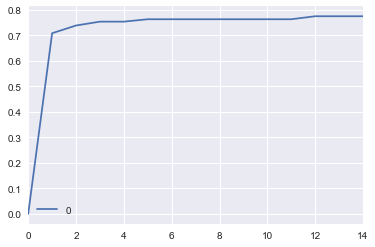

In [23]:
dfPlot = pd.DataFrame(accuracies)
plt.figure()
dfPlot.plot.line()

print(np.mean(test_acc))

A seguir o mesmo procedimento é feito, mas agora aumentando a quantidade de iterações para 30. A precisão final para os treinos ficou na casa dos 78% novamente, e a precisão dos testes por volta de 77%. Neste caso o tempo de execução foi consideravelmente maior e a precisão não melhorou muito.

In [24]:
n_iterations = 30

boost = Boost(20, n_iterations)
accuracies = n_iterations*[0]
test_acc = []
for train, test in cross_validation_split(n_folds, X, y):
    X_train = train[:, :9]
    y_train = train[:, -1]
    
    fit = boost.fit(X_train, y_train)
    accuracies = list(map(sum, zip(accuracies, fit['accuracy'])))
    
    X_test = test[:, :9]
    y_test = test[:, -1]
    pred = boost.predict(X_test)
    right = [pred[i] == y_test[i] for i in range(len(y_test))]
    test_acc.append(sum(right) / len(y_test))
    
accuracies = [x / n_folds for x in accuracies]

Done
Done
Done
Done
Done


0.7755973130238993


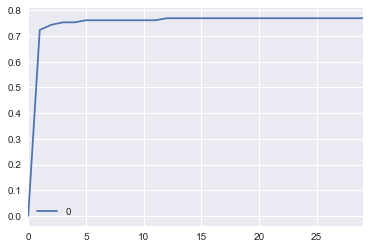

In [28]:
dfPlot = pd.DataFrame(accuracies)
plt.figure()
dfPlot.plot.line()

print(np.mean(test_acc))

A seguir também foi feito um teste com 10 iterações. Tanto a precisão de treino quanto de teste ficou na casa de 75%. Como o desempenho com 15 iterações é um pouco melhor e o tempo de execução não é tão maior, daqui para frente os testes serão feitos com 15 iterações.

In [29]:
n_iterations = 10

boost = Boost(20, n_iterations)
accuracies = n_iterations*[0]
test_acc = []
for train, test in cross_validation_split(n_folds, X, y):
    X_train = train[:, :9]
    y_train = train[:, -1]
    
    fit = boost.fit(X_train, y_train)
    accuracies = list(map(sum, zip(accuracies, fit['accuracy'])))
    
    X_test = test[:, :9]
    y_test = test[:, -1]
    pred = boost.predict(X_test)
    right = [pred[i] == y_test[i] for i in range(len(y_test))]
    test_acc.append(sum(right) / len(y_test))
    
accuracies = [x / n_folds for x in accuracies]

Done
Done
Done
Done
Done


0.7506617407698777


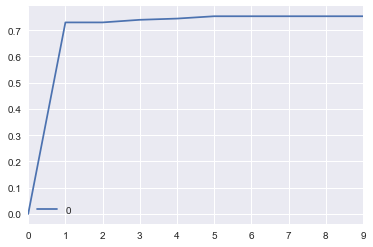

In [30]:
dfPlot = pd.DataFrame(accuracies)
plt.figure()
dfPlot.plot.line()

print(np.mean(test_acc))

Finalizando os experimentos, o código a seguir é usado para treinar modelos com 15 iterações, variando a quantidade de *stumps* em 5, 9, 13, 17 e 20. A precisão de treino e de teste em cada um dos modelos é guardada para se tomar as conclusões finais. Também os valores de *epsilon* são salvos para avaliar sua tendência final.

In [82]:
n_folds = 5
n_iterations = 15

es = []
test_accuracies = []
train_accuracies = []
for n_estimators in [5, 9, 13, 17, 20]:
    boost = Boost(n_estimators, n_iterations)
    accuracies = n_iterations*[0]
    test_acc = []
    cv_es = []
    for train, test in cross_validation_split(n_folds, X, y):
        X_train = train[:, :9]
        y_train = train[:, -1]

        fit = boost.fit(X_train, y_train)
        accuracies = list(map(sum, zip(accuracies, fit['accuracy'])))

        X_test = test[:, :9]
        y_test = test[:, -1]
        pred = boost.predict(X_test)
        right = [pred[i] == y_test[i] for i in range(len(y_test))]
        test_acc.append(sum(right) / len(y_test))
        cv_es.append(fit['e'])

    accuracies = [x / n_folds for x in accuracies]
    es.append(np.mean(cv_es))
    train_accuracies.append(max(accuracies))
    test_accuracies.append(np.mean(test_acc))

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


O código a seguir foi utlizado para se plotar o erro de treino e de teste utilizando-se 5, 9, 13, 17 e 20 *stumps*. Também é possível ver o valor de *epsilon* dos modelos treinados. Como se pode observar, o erro dos treinos e testes vai caindo à medida que se adiciona *stumps*, já que com maior quantidade de modelos fracos "votando" nas classificações corretas, a precisão aumenta. Também é perceptível a tendência do valor de *epsilon* subir até a proximidade de 0,5. O valor de *epsilon* é o peso dos erros do melhor *stump* (*h*) escolhido, e este valor tende a subir porque à medida que as iterações passam, vão sobrando modelos cada vez piores, conforme visto em sala de aula.

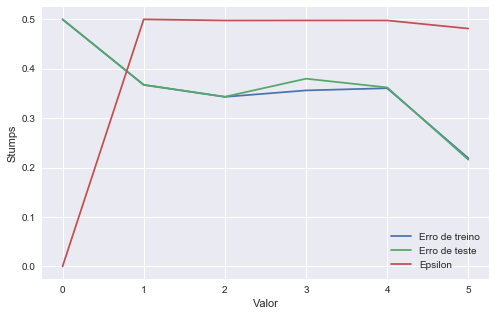

In [158]:
train_err = [1 - x for x in train_accuracies]
train_err.insert(0, 0.5)
test_err = [1 - x for x in test_accuracies]
test_err.insert(0, 0.5)
print_es = es.copy()
print_es.insert(0, 0)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(6), train_err, label='Erro de treino')
plt.plot(np.arange(6), test_err, label='Erro de teste')
plt.plot(np.arange(6), print_es, label='Epsilon')
plt.xlabel('Valor')
plt.ylabel('Stumps')
plt.legend(loc='best')
plt.show()

## Conclusão:
Conclui-se que, pelo desenvolvimento deste trabalho, maior experiência com o processo de *Booting* foi atingida. O algoritmo implementado colocou em prática e reforçou com êxito os conceitos vistos em sala de aula. No final, um modelo com precisão interessante foi alcançado, utilizando 15 iterações e 20 *stumps*. A precisão do teste deste modelo girou em torno dos 76% para a base do *tic-tac-toe* utilizada. Com uma base maior, talvez o modelo chegasse a uma precisão ainda melhor, com um treino mais completo. Também foram colocados em prática os conceitos de *cross validation* (validação cruzada), incluindo seu formato estratificado. Melhorias podem ser feitas no intuito de se criar um código mais genêrico, não tão específico para a base do *tic-tac-toe* utilizada. Também pode-se acrescentar melhorias com o intuito de se alcançar melhor desempenho e a velocidade de processamento. Conclui-se então que os objetivos foram alcançados com êxito.